In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [38]:
start = pd.Timestamp("2014-12-15 10:00:00+01:00")
end = pd.Timestamp("2025-11-05", tz="CET")
# df = build_dataset(start, end)
# df.to_csv("backup.csv")

df = pd.read_csv("backup.csv", index_col=0, parse_dates=True)
df = df.asfreq('h')
df

,day_sin,day_cos,month_sin,month_cos,dow_sin,dow_cos,is_weekend,hour_sin,hour_cos,load,temp
2014-12-15 10:00:00+01:00,0.101168,-0.994869,-2.449294e-16,1.000000,0.000000,1.00000,0,7.071068e-01,-7.071068e-01,72729.00,7.13
2014-12-15 11:00:00+01:00,0.101168,-0.994869,-2.449294e-16,1.000000,0.000000,1.00000,0,5.000000e-01,-8.660254e-01,73107.00,7.94
2014-12-15 12:00:00+01:00,0.101168,-0.994869,-2.449294e-16,1.000000,0.000000,1.00000,0,2.588190e-01,-9.659258e-01,73077.00,8.62
2014-12-15 13:00:00+01:00,0.101168,-0.994869,-2.449294e-16,1.000000,0.000000,1.00000,0,1.224647e-16,-1.000000e+00,71859.00,9.17
2014-12-15 14:00:00+01:00,0.101168,-0.994869,-2.449294e-16,1.000000,0.000000,1.00000,0,-2.588190e-01,-9.659258e-01,70910.00,9.68
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-04 19:00:00+01:00,0.724793,0.688967,-5.000000e-01,0.866025,0.781831,0.62349,0,-1.000000e+00,-1.836970e-16,55355.50,14.53
2025-11-04 20:00:00+01:00,0.724793,0.688967,-5.000000e-01,0.866025,0.781831,0.62349,0,-9.659258e-01,2.588190e-01,52126.75,13.81
2025-11-04 21:00:00+01:00,0.724793,0.688967,-5.000000e-01,0.866025,0.781831,0.62349,0,-8.660254e-01,5.000000e-01,49397.00,13.33
2025-11-04 22:00:00+01:00,0.724793,0.688967,-5.000000e-01,0.866025,0.781831,0.62349,0,-7.071068e-01,7.071068e-01,49807.75,13.05


In [39]:
# Since thre are only few missing values (no big gap), we can use simple imputation methods such as forward fill.
df["load"] = df["load"].ffill()

# missing values over the whole dataframe
total_missing = df.isna().sum()
print(f"Total missing values after imputation: {total_missing}")

Total missing values after imputation: day_sin       0
day_cos       0
month_sin     0
month_cos     0
dow_sin       0
dow_cos       0
is_weekend    0
hour_sin      0
hour_cos      0
load          0
temp          0
dtype: int64


# Reminder : Naive performance to beat -> Naive MAE: 2851.37 MW


# Let's take last week as input

In [49]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

INPUT_LEN = 24*7   # 1 semaine d'historique
OUTPUT_LEN = 24   # 24 heures à prévoir
FEATURE_COLS = list(df.columns)
TARGET_COL = 'load'
STEP = 24


features = df[FEATURE_COLS].values
target = df[TARGET_COL].values

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))

def make_sequences(X, y, input_len=INPUT_LEN, output_len=OUTPUT_LEN, step=STEP):
    X_seq, y_seq = [], []
    for i in range(input_len, len(X)-output_len+1, step):
        X_seq.append(X[i-input_len:i])
        y_seq.append(y[i:i+output_len])
    return np.array(X_seq), np.array(y_seq).reshape(-1, output_len, 1)

X, y = make_sequences(features_scaled, target_scaled)
n_train = int(len(X)*0.8)
X_train, y_train, X_test, y_test = X[:n_train], y[:n_train], X[n_train:], y[n_train:]

# LSTM(10) + Dense(50) (avec un dropout de 20%)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.1024 - val_loss: 0.0147
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0151 - val_loss: 0.0080
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0081 - val_loss: 0.0064
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 11/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 12/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

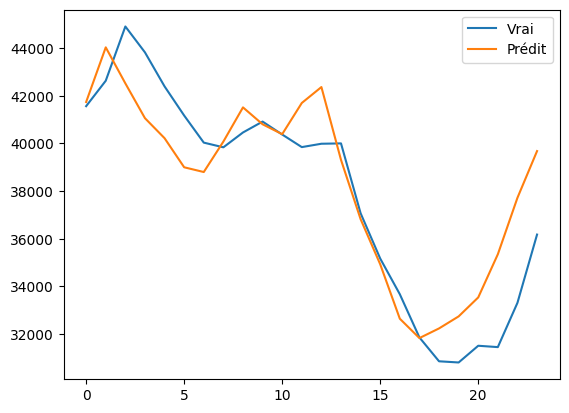

In [42]:
inputs = layers.Input(shape=(INPUT_LEN, len(FEATURE_COLS)))
h = layers.LSTM(10)(inputs)
d = layers.Dropout(0.2)(h)
h = layers.Dense(50, activation='relu')(d)
outputs = layers.Dense(OUTPUT_LEN)(h)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, verbose=1)

y_pred = model.predict(X_test)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred_inv)
print(f"MAE = {mae:.2f}")

plt.plot(y_true[:24], label='Vrai')
plt.plot(y_pred_inv[:24], label='Prédit')
plt.legend()
plt.show()


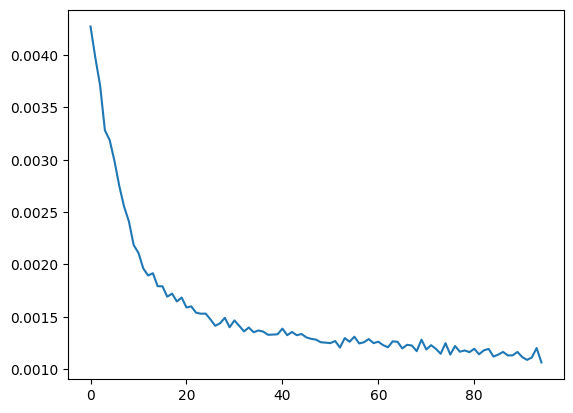

In [43]:
plt.plot(history.history["loss"][5:])

# LSTM(50) + Dense(50) (avec un dropout de 20%)

Epoch 1/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.0750 - val_loss: 0.0071
Epoch 2/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0078 - val_loss: 0.0032
Epoch 3/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 4/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 5/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 6/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 7/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 8/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 9/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 10/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 11/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 12/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 

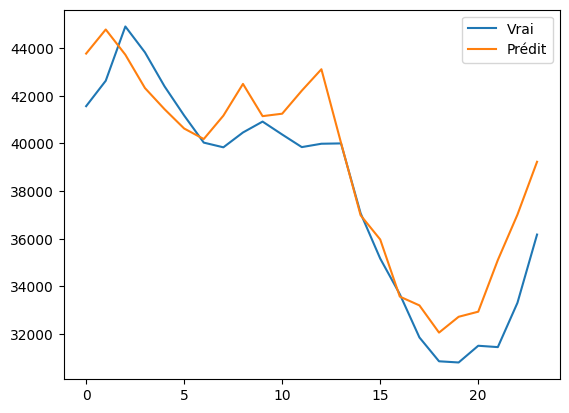

In [44]:
inputs = layers.Input(shape=(INPUT_LEN, len(FEATURE_COLS)))
h = layers.LSTM(50)(inputs)
d = layers.Dropout(0.2)(h)
h = layers.Dense(50, activation='relu')(d)
outputs = layers.Dense(OUTPUT_LEN)(h)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, validation_split=0.1, epochs=80, batch_size=32, verbose=1)

y_pred = model.predict(X_test)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred_inv)
print(f"MAE = {mae:.2f}")

plt.plot(y_true[:24], label='Vrai')
plt.plot(y_pred_inv[:24], label='Prédit')
plt.legend()
plt.show()


Epoch 1/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0484 - val_loss: 0.0058
Epoch 2/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 3/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 4/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 11/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 12/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0

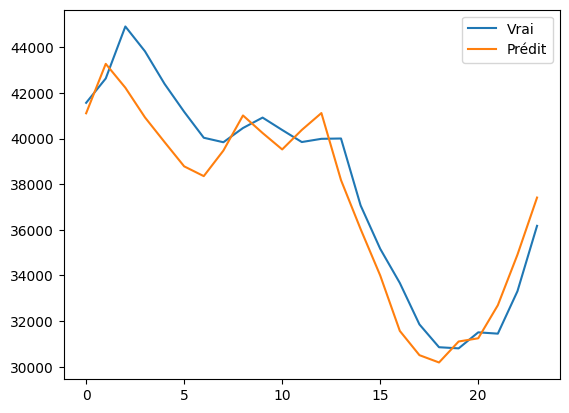

In [45]:
model = tf.keras.Sequential([
    layers.Input(shape=(INPUT_LEN, len(FEATURE_COLS))),
    layers.LSTM(64),
    layers.Dense(50),
    layers.Dense(OUTPUT_LEN)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, validation_split=0.1, epochs=64, batch_size=32, verbose=1)

y_pred = model.predict(X_test)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred_inv)
print(f"MAE = {mae:.2f}")

plt.plot(y_true[:24], label='Vrai')
plt.plot(y_pred_inv[:24], label='Prédit')
plt.legend()
plt.show()


Epoch 1/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0971 - val_loss: 0.0122
Epoch 2/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0057 - val_loss: 0.0063
Epoch 3/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 4/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 5/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 6/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 7/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 8/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 9/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 10/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 11/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 12/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0

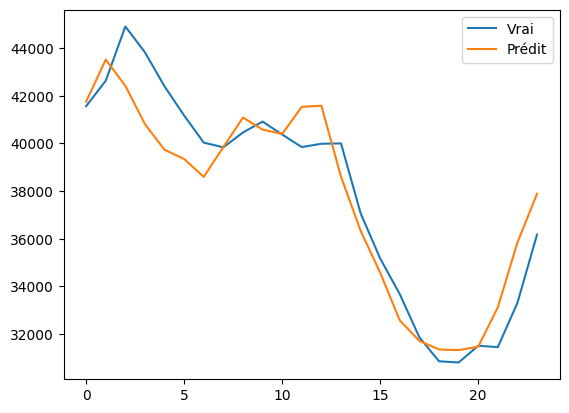

In [51]:
inputs = layers.Input(shape=(INPUT_LEN, len(FEATURE_COLS)))
h = layers.LSTM(32)(inputs)
d = layers.Dense(32)(h)
outputs = layers.Dense(OUTPUT_LEN)(d)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, validation_split=0.1, epochs=64, batch_size=32, verbose=1)

y_pred = model.predict(X_test)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred_inv)
print(f"MAE = {mae:.2f}")

plt.plot(y_true[:24], label='Vrai')
plt.plot(y_pred_inv[:24], label='Prédit')
plt.legend()
plt.show()


# Progresse un peu mais pas tant que ça,

idée : introduire un forecast de température

In [47]:
# Supposons un forecast parfait
df["f_temp"] = df.temp.shift(-1).ffill()
df.f_temp

,f_temp
2014-12-15 10:00:00+01:00,7.94
2014-12-15 11:00:00+01:00,8.62
2014-12-15 12:00:00+01:00,9.17
2014-12-15 13:00:00+01:00,9.68
2014-12-15 14:00:00+01:00,9.79
...,...
2025-11-04 19:00:00+01:00,13.81
2025-11-04 20:00:00+01:00,13.33
2025-11-04 21:00:00+01:00,13.05
2025-11-04 22:00:00+01:00,12.84


In [ ]:
INPUT_LEN = 24*7   # 1 semaine d'historique
OUTPUT_LEN = 24   # 24 heures à prévoir
FEATURE_COLS = list(df.columns).remove("temp")
TARGET_COL = 'load'
STEP = 24

features = df[FEATURE_COLS].values
target = df[TARGET_COL].values

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))

def make_sequences(X, y, input_len=INPUT_LEN, output_len=OUTPUT_LEN, step=STEP):
    X_seq, y_seq = [], []
    for i in range(input_len, len(X)-output_len+1, step):
        X_seq.append(X[i-input_len:i])
        y_seq.append(y[i:i+output_len])
    return np.array(X_seq), np.array(y_seq).reshape(-1, output_len, 1)

X, y = make_sequences(features_scaled, target_scaled)
n_train = int(len(X)*0.8)
X_train, y_train, X_test, y_test = X[:n_train], y[:n_train], X[n_train:], y[n_train:]

training model...
Epoch 1/32
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.2486 - val_loss: 0.0533
Epoch 2/32
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0466 - val_loss: 0.0265
Epoch 3/32
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0243 - val_loss: 0.0196
Epoch 4/32
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0178 - val_loss: 0.0160
Epoch 5/32
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 6/32
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0100 - val_loss: 0.0106
Epoch 7/32
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 8/32
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 9/32
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 10/32
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 11/32
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 12/32
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22m

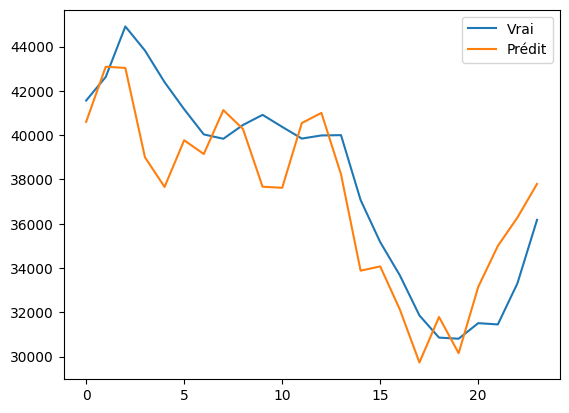

In [52]:
inputs = layers.Input(shape=(INPUT_LEN, len(FEATURE_COLS)))
x = layers.SimpleRNN(10, activation='tanh')(inputs)
# x = LSTM(50)(inputs)
# x = GRU(50)(inputs)
outputs = layers.Dense(OUTPUT_LEN)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

print("training model...")
history = model.fit(X_train, y_train, validation_split=0.1, epochs=32, batch_size=32, verbose=1)
print("model trained.")

y_pred = model.predict(X_test)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred_inv)
print(f"MAE = {mae:.2f}")

plt.plot(y_true[:24], label='Vrai')
plt.plot(y_pred_inv[:24], label='Prédit')
plt.legend()
plt.show()


training model...
Epoch 1/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2082 - val_loss: 0.0456
Epoch 2/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0372 - val_loss: 0.0258
Epoch 3/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0207 - val_loss: 0.0205
Epoch 4/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0162 - val_loss: 0.0166
Epoch 5/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0123 - val_loss: 0.0136
Epoch 6/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0095 - val_loss: 0.0117
Epoch 7/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0076 - val_loss: 0.0090
Epoch 8/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0067 - val_loss: 0.0077
Epoch 9/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0057 - val_loss: 0.0071
Epoch 10/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0049 - val_loss: 0.0063
Epoch 11/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 12/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33m

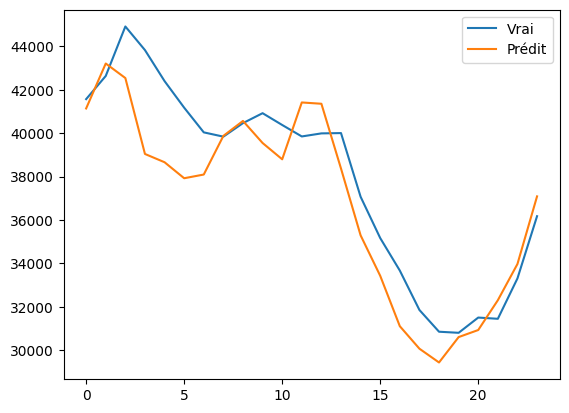

In [53]:
inputs = layers.Input(shape=(INPUT_LEN, len(FEATURE_COLS)))
x = layers.SimpleRNN(10, activation='tanh')(inputs)
# x = LSTM(50)(inputs)
# x = GRU(50)(inputs)
outputs = layers.Dense(OUTPUT_LEN)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

print("training model...")
history = model.fit(X_train, y_train, validation_split=0.1, epochs=64, batch_size=32, verbose=1)
print("model trained.")

y_pred = model.predict(X_test)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred_inv)
print(f"MAE = {mae:.2f}")

plt.plot(y_true[:24], label='Vrai')
plt.plot(y_pred_inv[:24], label='Prédit')
plt.legend()
plt.show()


training model...
Epoch 1/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.1427 - val_loss: 0.0294
Epoch 2/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0252 - val_loss: 0.0188
Epoch 3/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 4/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0099 - val_loss: 0.0132
Epoch 5/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0078 - val_loss: 0.0103
Epoch 6/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0060 - val_loss: 0.0078
Epoch 7/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0050 - val_loss: 0.0069
Epoch 8/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 9/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 10/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 11/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 12/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 58

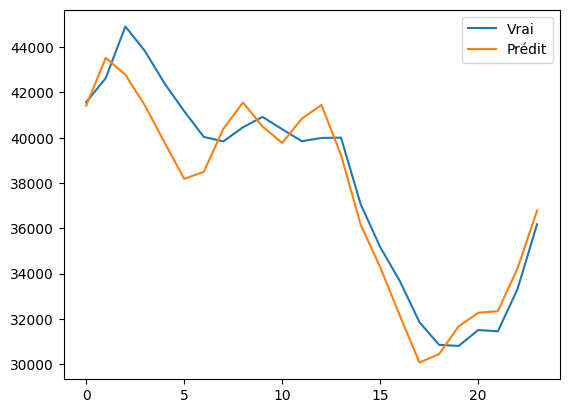

In [54]:
inputs = layers.Input(shape=(INPUT_LEN, len(FEATURE_COLS)))
x = layers.GRU(10)(inputs)
# x = LSTM(50)(inputs)
# x = GRU(50)(inputs)
outputs = layers.Dense(OUTPUT_LEN)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

print("training model...")
history = model.fit(X_train, y_train, validation_split=0.1, epochs=64, batch_size=32, verbose=1)
print("model trained.")

y_pred = model.predict(X_test)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred_inv)
print(f"MAE = {mae:.2f}")

plt.plot(y_true[:24], label='Vrai')
plt.plot(y_pred_inv[:24], label='Prédit')
plt.legend()
plt.show()


training model...
Epoch 1/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.1125 - val_loss: 0.0116
Epoch 2/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 3/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 4/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 5/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 6/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 7/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 8/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 9/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 10/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 11/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 12/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45m

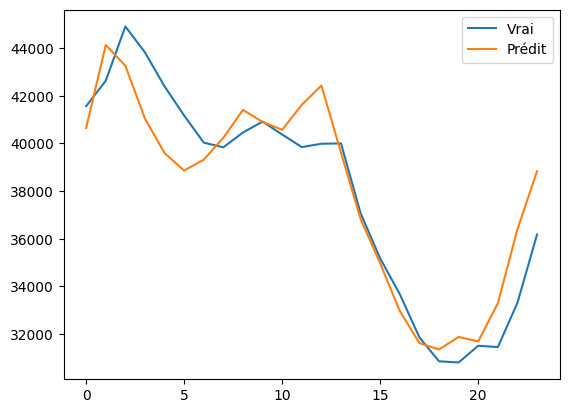

In [55]:
inputs = layers.Input(shape=(INPUT_LEN, len(FEATURE_COLS)))
x = layers.LSTM(32)(inputs)
# x = LSTM(50)(inputs)
# x = GRU(50)(inputs)
outputs = layers.Dense(OUTPUT_LEN)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

print("training model...")
history = model.fit(X_train, y_train, validation_split=0.1, epochs=64, batch_size=32, verbose=1)
print("model trained.")

y_pred = model.predict(X_test)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred_inv)
print(f"MAE = {mae:.2f}")

plt.plot(y_true[:24], label='Vrai')
plt.plot(y_pred_inv[:24], label='Prédit')
plt.legend()
plt.show()


# Let's retry with our best candidate

Epoch 1/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1246 - val_loss: 0.0171
Epoch 2/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0151 - val_loss: 0.0078
Epoch 3/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0078 - val_loss: 0.0053
Epoch 4/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 5/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 6/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 7/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 8/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 9/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 10/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 11/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 12/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0

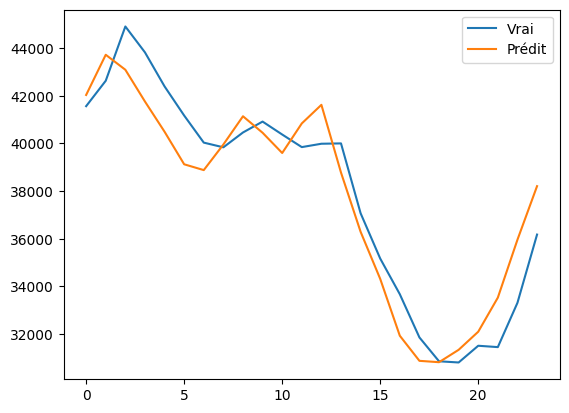

In [58]:
inputs = layers.Input(shape=(INPUT_LEN, len(FEATURE_COLS)))
h = layers.LSTM(16)(inputs)
dr = layers.Dropout(0.1)(h)
de = layers.Dense(16)(dr)
outputs = layers.Dense(OUTPUT_LEN)(de)
lstm_dense_t_forecast = tf.keras.Model(inputs, outputs)

lstm_dense_t_forecast.compile(optimizer='adam', loss='mse')

history = lstm_dense_t_forecast.fit(X_train, y_train, validation_split=0.1, epochs=64, batch_size=32, verbose=1)

y_pred = lstm_dense_t_forecast.predict(X_test)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred_inv)
print(f"MAE = {mae:.2f}")

plt.plot(y_true[:24], label='Vrai')
plt.plot(y_pred_inv[:24], label='Prédit')
plt.legend()
plt.show()


# Let's try some more complex architextures

## Seq2Seq LSTM

training model...
Epoch 1/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 225ms/step - loss: 0.0196 - val_loss: 0.0046
Epoch 2/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 3/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 4/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 5/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 8/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 11/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 12/64
90/90 ━━━━━

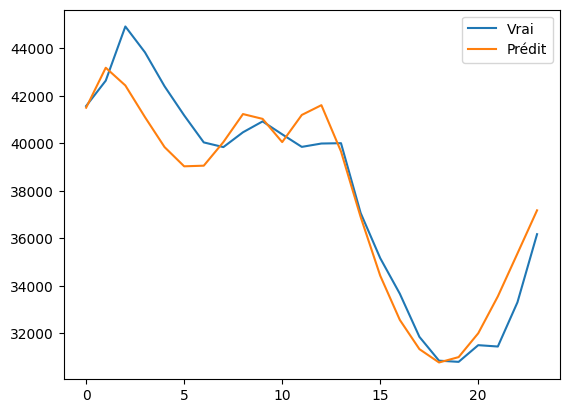

In [56]:
encoder_inputs = layers.Input(shape=(INPUT_LEN, len(FEATURE_COLS)))
encoder = layers.LSTM(128, return_state=True)
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = layers.RepeatVector(OUTPUT_LEN)(state_h)
decoder_lstm = layers.LSTM(128, return_sequences=True)(decoder_inputs, initial_state=encoder_states)
decoder_outputs = layers.TimeDistributed(layers.Dense(1))(decoder_lstm)

model = tf.keras.Model(encoder_inputs, decoder_outputs)

model.compile(optimizer='adam', loss='mse')

print("training model...")
history = model.fit(X_train, y_train, validation_split=0.1, epochs=64, batch_size=32, verbose=1)
print("model trained.")

y_pred = model.predict(X_test)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred_inv)
print(f"MAE = {mae:.2f}")

plt.plot(y_true[:24], label='Vrai')
plt.plot(y_pred_inv[:24], label='Prédit')
plt.legend()
plt.show()


Epoch 1/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 383ms/step - loss: 0.0311 - val_loss: 0.0061
Epoch 2/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 373ms/step - loss: 0.0058 - val_loss: 0.0078
Epoch 3/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 379ms/step - loss: 0.0049 - val_loss: 0.0068
Epoch 4/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 366ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 5/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 374ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 6/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 7/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 371ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 8/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 370ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 381ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 10/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 379ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 11/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 383ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 12/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 34

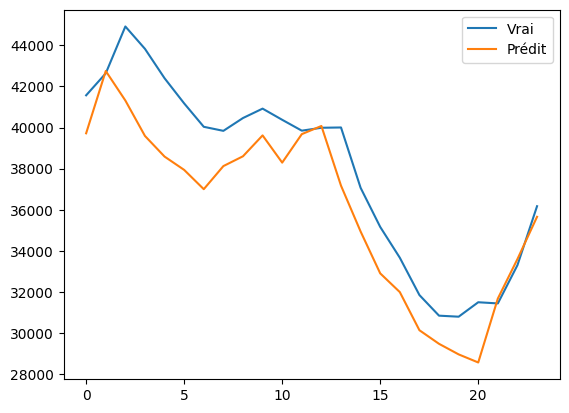

In [59]:
inputs = layers.Input(shape=(INPUT_LEN, len(FEATURE_COLS)))
x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(inputs)
attention = layers.Attention()([x, x])
x = layers.Concatenate()([x, attention])
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(OUTPUT_LEN)(x)

attention_model = tf.keras.Model(inputs, outputs)

attention_model.compile(optimizer='adam', loss='mse')

history = attention_model.fit(X_train, y_train, validation_split=0.1, epochs=64, batch_size=32, verbose=1)

y_pred = attention_model.predict(X_test)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred_inv)
print(f"MAE = {mae:.2f}")

plt.plot(y_true[:24], label='Vrai')
plt.plot(y_pred_inv[:24], label='Prédit')
plt.legend()
plt.show()


Ne change pas grand chose...

# Finally our winner is

In [69]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

INPUT_LEN = 24*7   # 1 semaine d'historique
OUTPUT_LEN = 24   # 24 heures à prévoir
FEATURE_COLS = [col for col in df.columns if col != "f_temp"]
TARGET_COL = 'load'
STEP = 24


features = df[FEATURE_COLS].values
target = df[TARGET_COL].values

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))

def make_sequences(X, y, input_len=INPUT_LEN, output_len=OUTPUT_LEN, step=STEP):
    X_seq, y_seq = [], []
    for i in range(input_len, len(X)-output_len+1, step):
        X_seq.append(X[i-input_len:i])
        y_seq.append(y[i:i+output_len])
    return np.array(X_seq), np.array(y_seq).reshape(-1, output_len, 1)

X, y = make_sequences(features_scaled, target_scaled)
n_train = int(len(X)*0.8)
X_train, y_train, X_test, y_test = X[:n_train], y[:n_train], X[n_train:], y[n_train:]

Epoch 1/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0822 - val_loss: 0.0086
Epoch 2/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 3/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 4/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 5/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 6/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 8/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 9/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 10/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 11/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 12/64
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0

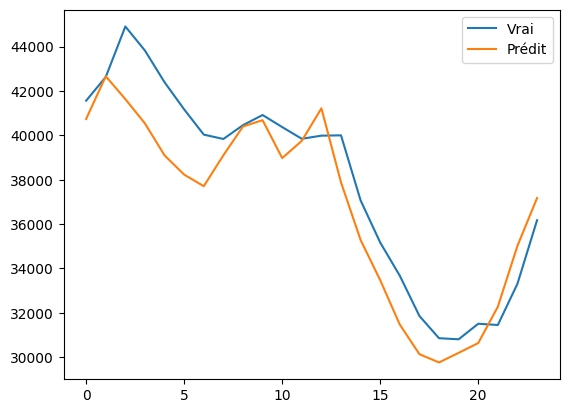

In [71]:
inputs = layers.Input(shape=(INPUT_LEN, len(FEATURE_COLS)))
h = layers.LSTM(32)(inputs)
de = layers.Dense(32)(h)
outputs = layers.Dense(OUTPUT_LEN)(de)
lstm_dense = tf.keras.Model(inputs, outputs)

lstm_dense.compile(optimizer='adam', loss='mse')

history = lstm_dense.fit(X_train, y_train, validation_split=0.1, epochs=64, batch_size=32, verbose=1)

y_pred = lstm_dense.predict(X_test)
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred_inv)
print(f"MAE = {mae:.2f}")

plt.plot(y_true[:24], label='Vrai')
plt.plot(y_pred_inv[:24], label='Prédit')
plt.legend()
plt.show()


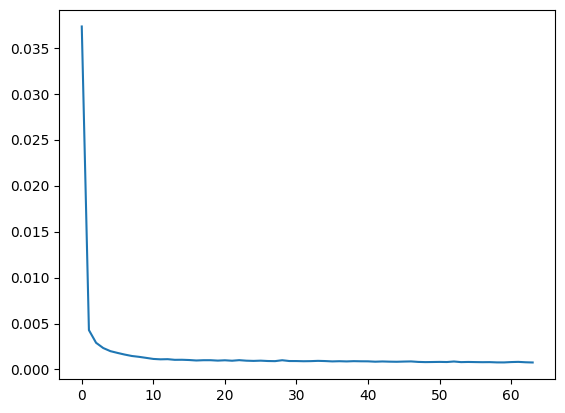

In [86]:
plt.plot(lstm_dense.history.history['loss'])

# Prevision de la consommation française le 7 novembre

In [115]:
last_week = pd.read_csv("last_week.csv", index_col=0, parse_dates=True)
last_week_values = last_week[FEATURE_COLS].values
last_week_values_scaled = scaler_X.transform(last_week_values)
last_week_values_scaled = last_week_values_scaled.reshape((1, INPUT_LEN, len(FEATURE_COLS)))
tomorrow_pred_scaled = lstm_dense.predict(last_week_values_scaled)
tomorrow_pred = scaler_y.inverse_transform(tomorrow_pred_scaled.reshape(-1,1))
tomorrow_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


array([[42592.83 ],
       [43747.094],
       [51924.87 ],
       [51140.99 ],
       [51226.113],
       [42998.207],
       [51048.453],
       [55676.934],
       [56159.914],
       [57243.367],
       [53031.14 ],
       [51078.49 ],
       [54100.395],
       [51891.363],
       [50426.098],
       [48030.312],
       [47417.152],
       [44316.906],
       [45738.06 ],
       [44790.094],
       [48534.656],
       [50094.58 ],
       [51310.418],
       [52418.434]], dtype=float32)

<Axes: >

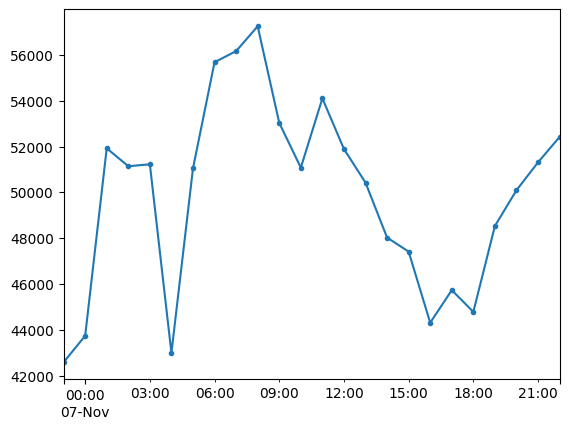

In [116]:
index = pd.date_range(start=last_week.index[-1], periods=24, freq='h')
pd.Series(tomorrow_pred.reshape(-1), index=index).plot(marker=".")

# Pistes d'amélioration:
* trouver les features les plus importantes
* reduire le step
* physics-informed neural networks